In [ ]:
#| hide
from nbdev import *

# OUScope

> The `ouscope` is a library providing python interface to the Open University Autonomous Robotic Telescope facility at telescope.org

The library provides access and control for the telescope. The functions help with job submission, image retrival and initial analysis. For naw this is aimed at variable star observations, but there is nothing prohibiting additional modules intended for different fields (e.g. astrometry).

## Install

The package is not yet published to pypi/conda, thus for now the only way to install it is the developer-style install. I recommend the following sequence:

```bash
git clone https://github.com/jochym/ouscope.git
cd ouscope
python3 -m venv venv 
. venv/bin/activate

pip install -e .
```

Later on you just go to the ouscope directory and run:
```bash
. venv/bin/activate
```
to activate the virtual environment.

### Update
With developer install the upgrade is simple, `git pull` should do the trick :
```bash
cd ouscope
git pull
```
When the set of dependecies changes you may need to
```bash
pip uninstall ouscope ; pip install -e .
```

to refresh your setup.

## How to use

The library is not ready but you can try to use it for some tasks. Before this example will run you need to have some additional setup:

- Local AstrometryNet solver (`solve-field` command) installed and configured. It is possible to use nova.astrometry.net solver but the automatic interaction/switching is not complete yet. You can modify the example to use it (see `Solver` docs for some guidance)
- The config file for your telescope.org account. The cache directories will be created in the current working directory with this setup. You may move them to some other place (e.g. `~/.cache/ouscope`):
```
[cache]
wcs=.cache/wcs
jobs=.cache/jobs
seq=.cache/seq

[telescope.org]
user=jour_user_name
password=your_password

[astrometry.net]
apikey=your_astrometry.net_api_key

```

If it still does not work, please submit a github issue. I do not have many systems to test the library on. Below is a simple example.

### Interacting with telescope.org

The code below:
- creates the `Telescope` object `scope`
- automatically logs-in to the user from the config file
- lists user folders
- gets user requests sorted by request ID (i.e. submission order)
- goes over the list until five completed requests are listed
- downloads the latest completed job into `obs` variable
- prints JobID:RequestID, target name, 

In [ ]:
#| login
#|code-fold: true
from ouscope.core import Telescope

scope=Telescope(config='~/.config/telescope.ini')

print("User folders:")
for f in scope.get_user_folders():
    cnt = f["count"] 
    if cnt is None:
        cnt = 0
    print(f'{f["name"]:>12} ({f["id"]:>3}): {cnt:>4} items')

reqlst=scope.get_user_requests(sort='rid')

print(f'\nUser {scope.user} has {len(reqlst)} requests.')
print("\nThe most recent requests:")
last_complete = None
complete = []
n = 5
for rq in reqlst:
    jid = scope.get_jid_for_req(rq)
    print(f'{rq["id"]}: {rq["objectname"]:15} jid: {(jid if jid else ""):6}', end=' ')
    print(f'{Telescope.REQUESTSTATUS_TEXTS[int(rq["status"])]}')
    if rq["status"]=='8':
        complete.append(jid)
        if last_complete is None:
            last_complete = jid
        n -= 1
    if n<0 :
        break
print()

jid = complete[0]
# Let us show the newest job
job = scope.get_job(int(jid))
req = scope.get_request(int(job['rid']))
target = req['name'].lstrip().rstrip()

print('The latest complete job:')
print(f'J{jid}:R{job["rid"]} ({target}) Completed at: {" ".join(job["completion"])}')

obs = scope.get_obs(job, verbose=True)

scope.logout()

User folders:
       Inbox (  1): 1720 items
  Favourites (  2):    0 items
     Archive (  3):  447 items
       Trash (  4):   63 items
    Complete (461):   13 items

User jochym has 1720 requests.

The most recent requests:
760531: EQ Lyr          jid:        New
760530: LX Cyg          jid:        New
760529: DQ Vul          jid:        New
760528: DX Vul          jid:        New
760527: V686 Cyg        jid:        New
760526: SS Cyg          jid:        New
760525: CH Cyg          jid:        New
760205: DQ Vul          jid: 413202 Complete
760204: DX Vul          jid: 413201 Complete
760203: V686 Cyg        jid: 413200 Complete
760202: IP Cyg          jid:        Waiting
760124: LX Cyg          jid: 413122 Complete
760123: EQ Lyr          jid: 413121 Complete
760122: SS Cyg          jid: 413120 Complete

The latest complete job:
J413202:R760205 (DQ Vul) Completed at: 14 December 2023 20:10:35 UTC
OK_WAIT                       
READY                         


### Analysis of the data

Let us plot and analyse the last completed job listed above.

The code below:
- opens the data downloaded above (`obs` variable)
- plate-solves the resultings fits data (with local AstrometryNet solver)
- creates WCS object from the solution
- plots the RGB image of the data with RA-DEC grid
- query the Vizier database for variable stars 0.25 deg from center
- mark all objects found on the picture

In [ ]:
#|code-fold: true
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
from ouscope.solver import Solver
from ouscope.process import make_color_image

In [ ]:
#| login
#|code-fold: true
solver = Solver()

hdu = fits.open(obs)[0]

wcs_head = solver.solve(hdu, tout=30)
wcs = WCS(wcs_head, naxis=2)
wcs.printwcs()

Solving for 5644BC43
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 2 /tmp/field-solverb4lz3sjc/tmpvpoposve.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 299.968935258 22.8122733346 
CRPIX : 845.046401978 811.336247683 
CD1_1 CD1_2  : -0.000466593770382 -6.05975347053e-06 
CD2_1 CD2_2  : -7.17872510289e-06 0.000465931891585 
NAXIS : 1536  1536  3


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


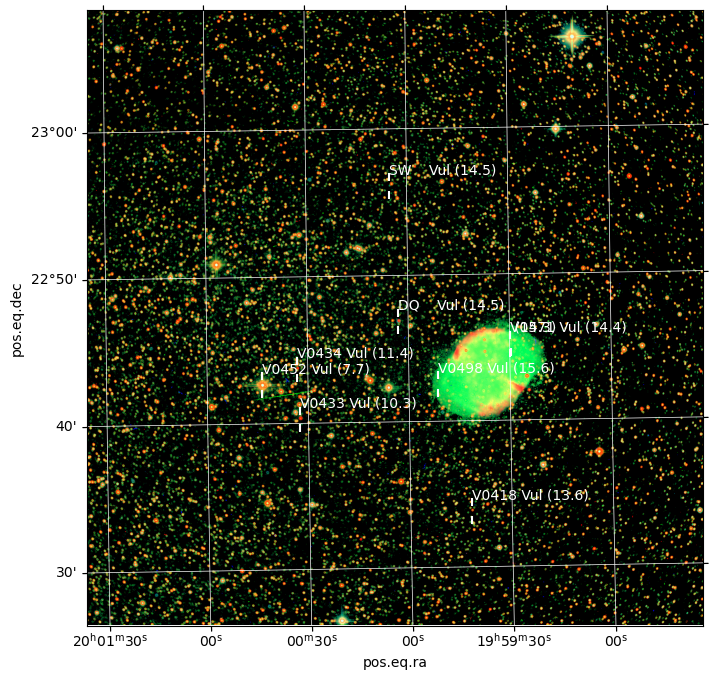

In [ ]:
#| login
#|code-fold: true
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection=wcs)
plt.grid(color='white', ls='solid', lw=0.5)

# crop the data to remove overscan noise
l, r, t, b = (0, 32, 0, 32)
plt.imshow(make_color_image(hdu.data[:, l:-r, t:-b],
                            order=hdu.header["FILTER"].split(",")))

center = wcs.pixel_to_world(wcs_head['NAXIS1']/2,wcs_head['NAXIS2']/2)
objects = Vizier.query_region(catalog='B/gcvs', 
                             coordinates=center, 
                             radius='0.25deg')
for g in objects:
    for n, o in enumerate(g):
        name = o['VarName']
        radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], 
                         frame='icrs', unit=(u.hourangle, u.deg))
        ax.scatter([radec.ra.deg, radec.ra.deg], 
                   [radec.dec.deg-0.01, radec.dec.deg+0.01], 
                   marker='|', s=30,
                   color='white',
                   transform=ax.get_transform('world'))
        ax.text(radec.ra.deg, radec.dec.deg+0.014, 
                f'{name} ({o["magMax"]:.1f})', 
                transform=ax.get_transform('world'), color='white')           




### List of objects (variable stars) in the frame 

In [ ]:
#|echo: false 
#|login
objects[0]

GCVS,n_GCVS,RAJ2000,DEJ2000,VarType,magMax,Period,SpType,Exists,VarName,Simbad
,,,,,mag,d,,,,
str10,str1,str11,str11,str10,float32,float64,str17,str12,str11,str6
SW Vul,x,20 00 05.21,+22 56 06.6,UGSS,14.500,15.0000000000,,,SW Vul,Simbad
DQ Vul,x,20 00 03.01,+22 46 51.7,M,14.500,310.0000000000,,,DQ Vul,Simbad
V0418 Vul,,19 59 41.89,+22 33 49.6,M:,13.600,--,,,V0418 Vul,Simbad
V0433 Vul,x,20 00 32.54,+22 40 15.4,SR:,10.300,--,,,V0433 Vul,Simbad
V0434 Vul,x,20 00 33.23,+22 43 41.2,SR:,11.400,--,,,V0434 Vul,Simbad
V0452 Vul,x,20 00 43.71,+22 42 39.0,BY,7.670,12.0390000000,G5V,,V0452 Vul,Simbad
V0498 Vul,*,19 59 51.29,+22 42 32.3,UGSU,15.600,--,,,V0498 Vul,Simbad
V0571 Vul,*,19 59 29.73,+22 45 13.1,M,14.400,214.0000000000,,,V0571 Vul,Simbad
